In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
data.shape

(10000, 13)

In [4]:
value_count=data['Exited'].value_counts()
value_count

Exited
0    7963
1    2037
Name: count, dtype: int64

In [5]:
Geography_count = data['Geography']. value_counts()
Geography_count


Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
label_encoder = LabelEncoder()

In [8]:
data['Geography'] = label_encoder.fit_transform(data['Geography'])

In [9]:
data.head()

,RowNumber,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,619,0,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,608,2,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,502,0,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,699,0,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,850,2,Female,43,2,125510.82,1,1,1,79084.10,0


In [10]:
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data.head()

,RowNumber,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [11]:
#data.to_csv("preprecessed_df.csv")

In [12]:
#drop a column by name (axis=1)
X_data = data.drop(labels= {'Exited', 'CustomerId', 'RowNumber'}, axis= 1)
y_data = data['Exited']

In [13]:
X_data.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,0,0,42,2,0.00,1,1,1,101348.88
1,608,2,0,41,1,83807.86,1,0,1,112542.58
2,502,0,0,42,8,159660.80,3,1,0,113931.57
3,699,0,0,39,1,0.00,2,0,0,93826.63
4,850,2,0,43,2,125510.82,1,1,1,79084.10


In [14]:
y_data.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=True, random_state=27)

In [16]:
!pip install xgboost

In [27]:
import xgboost
from xgboost import XGBClassifier
import matplotlib.pyplot as plt 

In [28]:
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance

In [29]:
def build_model(gamma=None, max_depth=None, min_child_weight=None,learning_rate=None,n_estimators=None,reg_alpha=None):
    model = xgb.XGBClassifier(
    learning_rate=(learning_rate or 0.1),
    n_estimators=(n_estimators or 1000),             # number of boosting / trees
    max_depth=(max_depth or 5),                      # max number of feature split on a tree
    min_child_weight=(min_child_weight or 1), 
    gamma=(gamma or 0),                              # min acceptable loss
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27,
    eval_metric='auc',
    reg_alpha=(reg_alpha or 0.01),
    )
    return model
    
def train_model(alg, x_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50): 
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    print("N_estimator from cv", alg.n_estimators)
    print("cvresult\n", cvresult)
    
    #Fit the algorithm on the data
    alg.fit(x_train, y_train)

    #Predict training set:
    dtrain_predictions = alg.predict(x_train)
    dtrain_predprob = alg.predict_proba(x_train)[:,1]
    print(alg.predict_proba(x_train))
    
    # #Print model report:
    print("\nModel Report")
    print( "Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))

    print("Feature Importance plot\n")


N_estimator from cv 76
cvresult
     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.834490       0.003407       0.820257      0.007175
1         0.851536       0.003210       0.836750      0.010134
2         0.854395       0.004827       0.840082      0.008719
3         0.856832       0.003344       0.842057      0.009322
4         0.858431       0.003156       0.843252      0.009228
..             ...            ...            ...           ...
71        0.920085       0.002897       0.864222      0.009999
72        0.920617       0.002859       0.864143      0.009998
73        0.921074       0.002800       0.864046      0.010225
74        0.921602       0.002961       0.864207      0.010265
75        0.922019       0.002995       0.864291      0.010332

[76 rows x 4 columns]
[[0.02205944 0.97794056]
 [0.95593554 0.04406444]
 [0.39262736 0.60737264]
 ...
 [0.7779731  0.2220269 ]
 [0.92408085 0.07591914]
 [0.33617932 0.6638207 ]]

Model Report
Accuracy : 0.8842


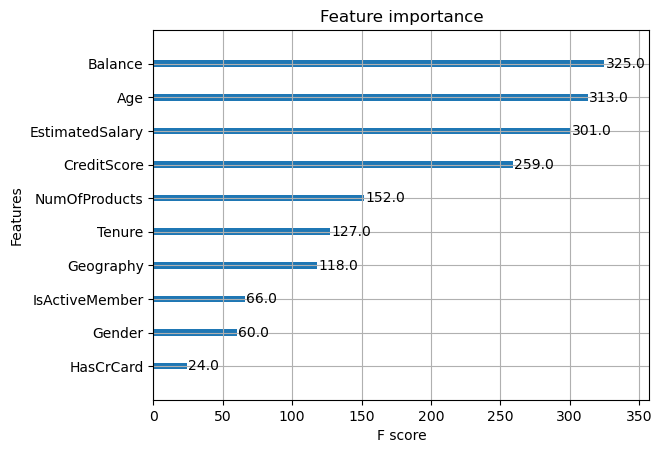

In [30]:
model = build_model()
train_model(model, x_train, y_train)
plot_importance(model)
plt.show()

Tune max_depth and min_child_weight.

In [31]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)

gsearch1.fit(x_train,y_train)
print("Train\n", gsearch1.best_params_, gsearch1.best_score_ )
gsearch1.fit(x_test,y_test)
print("Test\n", gsearch1.best_params_, gsearch1.best_score_)

Train
 {'max_depth': 3, 'min_child_weight': 3} 0.8630489128091068
Test
 {'max_depth': 3, 'min_child_weight': 1} 0.8474382574014421


Tune Gamma

In [32]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)

gsearch3.fit(x_train,y_train)
print("Train\n", gsearch3.best_params_, gsearch3.best_score_ )
gsearch3.fit(x_test,y_test)
print("Test\n", gsearch3.best_params_, gsearch3.best_score_)

Train
 {'gamma': 0.4} 0.8611825857742813
Test
 {'gamma': 0.2} 0.8345451756404356


Recalibrate the number of boosting rounds with above updated tuned parameters

In [33]:
# gamma:0.3, max_depth:3, min_child_weight:2
model = build_model(gamma=0.3, max_depth=3, min_child_weight=2)
train_model(model, x_train, y_train)

N_estimator from cv 98
cvresult
     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.789059       0.003463       0.786022      0.016449
1         0.806900       0.005368       0.803487      0.013459
2         0.809905       0.006405       0.804887      0.015170
3         0.816310       0.006590       0.810845      0.018289
4         0.819919       0.004206       0.815911      0.016209
..             ...            ...            ...           ...
93        0.885411       0.002562       0.861801      0.010201
94        0.885602       0.002482       0.861919      0.010217
95        0.885838       0.002474       0.862135      0.010268
96        0.886023       0.002508       0.862162      0.010343
97        0.886281       0.002566       0.862304      0.010352

[98 rows x 4 columns]
[[0.06481421 0.9351858 ]
 [0.9283789  0.07162113]
 [0.3564223  0.6435777 ]
 ...
 [0.795578   0.20442198]
 [0.8912599  0.10874007]
 [0.39021593 0.60978407]]

Model Report
Accuracy : 0.8704


Tune L1 Regularization - reg_alpha

In [34]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 2]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=3,
 min_child_weight=2, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4, cv=5)

gsearch7.fit(x_train, y_train)
gsearch7.best_params_, gsearch7.best_score_

({'reg_alpha': 0.5}, 0.8623137178306906)

Tune Learning Rate

In [35]:
param_test8 = {
 'learning_rate':[0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 2]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier(n_estimators=98, max_depth=3,
 min_child_weight=2, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test8, scoring='roc_auc',n_jobs=4, cv=5)

gsearch8.fit(x_train, y_train)
gsearch8.best_params_, gsearch8.best_score_

({'learning_rate': 0.1}, 0.8623413200145562)

Build and Train Final Parameter Tuned Model

In [36]:
gamma=0.3
max_depth=3
min_child_weight=2
learning_rate=0.1
n_estimators=98
reg_alpha=0.05

model = build_model(gamma, max_depth, min_child_weight,learning_rate,n_estimators,reg_alpha)

train_model = train_model(model, x_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50)

y_predicted = model.predict(x_test)

#predict_proba will predict the probability of classification into positive or negative, default threshhold=0.5
y_preds = model.predict_proba(x_test)
preds = y_preds[:,1]

N_estimator from cv 98
cvresult
     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.789059       0.003463       0.786022      0.016449
1         0.806900       0.005368       0.803487      0.013459
2         0.809911       0.006408       0.804887      0.015170
3         0.816316       0.006590       0.810846      0.018287
4         0.819922       0.004207       0.815908      0.016209
..             ...            ...            ...           ...
93        0.885507       0.002521       0.861782      0.010571
94        0.885705       0.002445       0.861883      0.010577
95        0.886003       0.002377       0.861978      0.010611
96        0.886281       0.002308       0.862046      0.010690
97        0.886562       0.002381       0.862036      0.010791

[98 rows x 4 columns]
[[0.04990602 0.950094  ]
 [0.93510085 0.06489913]
 [0.34830773 0.6516923 ]
 ...
 [0.79062366 0.20937632]
 [0.88831    0.11169   ]
 [0.4122405  0.5877595 ]]

Model Report
Accuracy : 0.8699


Prediction on test dataset

In [37]:
y_predicted = model.predict(x_test)

#predict_proba will predict the probability of classification into positive or negative, default threshhold=0.5
y_preds = model.predict_proba(x_test)
preds = y_preds[:,1]

Evaluation Metrics

In [38]:
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import math
from numpy import sqrt
from numpy import argmax

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
recall = tp/(tp + fn)
precision = tp / (tp + fp)

# Accuracy  - TP+FP / TP+FP+FN+TN
accuracy = (tp + fp) / (tp + fp + fn + tn)

# Precision-total percentage of positive identification
precision = tp / (tp + fp)

# Recall-total positive identification that were actually correct
recall = tp/(tp + fn)

# ROC curve- curve obtained by plotting TPR vs FPR for every threshold
# ROC AUC score-area under the ROC curve, determines which method/algo is better
auc_score = metrics.auc(fpr, tpr)

# F1-score  - harmonic mean of precision and recall
F1 = (2*(recall * precision)) / (recall + precision)

# g-means for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)

# Specificity= TN / TN+FP  - True Negative Rate, = 1-fpr
specificity = 1-fpr[ix]

# Sensitivity=Recall-what percentage in positive class were correctly identified - True Positive Rate
sensitivity = tpr[ix]

#g-mean
g_mean = math.sqrt(specificity*sensitivity)

# False Positive Rate= FP // FP+TN = 1 - Specificity

print("auc: ", auc_score)
print("g_mean: ", g_mean)
print("F1: ", F1)
print("sensitivity: ", sensitivity)
print("specificity: ", specificity)

auc:  0.8648627090044486
g_mean:  0.7792917280994819
F1:  0.6047904191616766
sensitivity:  0.8
specificity:  0.7591194968553459
